# CogPonder: A Model-Agnostic Approach to Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of human responses.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate a model-agnostic neural network that produces the speed-accuracy of the human decision making.

The network iterates over a recurrent decision model, terminating only when it reaches a halting step. Halting step is a decision step that is made when the network is confident enough to make a decision. The network is trained to minimize the difference between the human response time and the network's response time.


## Tasks

### 2-back Task

The subject is presented with a sequence of letters, and are asked to respond with "target" button whe the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock 2-back dataset to evaluate the architecture. The mock dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$ for each subject.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each time step is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution).

In case of the 2-back task, X is a moving window of recent 2 stimuli symbols, e.g., A, B, C, D, ...; and $y$ is either MATCH or NON_MATCH.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch.


### Criterion

$L = L_{rec} + L_{reg} + L_{target} + L_{non\_target}$ 


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from cogponder import NBackDataset, PonderNet, ICOM, evaluate

## Data

In [2]:


# generate mock n-back data

n_stimuli = 6

dataset = NBackDataset(n_subjects=2, n_trials=100, n_stimuli=6)

X, targets, responses, response_times = dataset[0]
dataset = TensorDataset(X, targets.float(), responses, response_times)

In [3]:
response_times.max()

tensor(52, dtype=torch.int32)

In [4]:
# evaluate the model

N_EPOCHS = 200
MAX_STEPS = response_times.max().detach() + 1
N_OUTPUTS = torch.unique(targets).size()[0]

model = PonderNet(ICOM, n_stimuli+1, n_stimuli, N_OUTPUTS, MAX_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = evaluate(model, dataset, optimizer, n_epochs=N_EPOCHS,
                   batch_size=4, max_steps=MAX_STEPS)

model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results

Epochs: 100%|██████████| 200/200 [00:06<00:00, 31.22it/s]


In [5]:

with torch.no_grad():
    model.eval()
    rt_test_pred = model(X_test)[2].float().detach()
    rt_train_pred = model(X_train)[2].float().detach()

rt_test_pred, rt_test

(tensor([ 8., 13.,  9., 11., 18., 22., 17., 15., 10., 16., 13., 12.,  3.,  7.,
          9., 24.,  8., 17.,  7., 11.]),
 tensor([52,  8, 18, 15,  8, 11, 18,  1,  9,  2,  9,  4,  5,  1,  4,  2,  2, 23,
          6, 13], dtype=torch.int32))

In [6]:
rt_test_pred.median(), rt_test.float().median()
rt_test_pred.median(), rt_train.float().median()


(tensor(11.), tensor(6.))

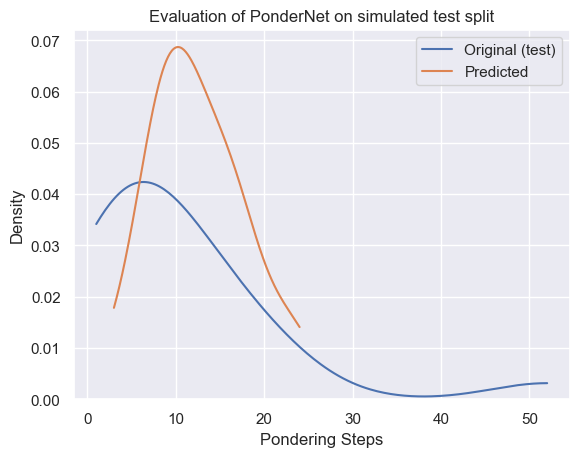

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(rt_test.detach(), label='Original (test)', cut=0)
sns.kdeplot(rt_test_pred.detach(), label='Predicted', cut=0)
# sns.kdeplot(rt_train, label='original', cut=0)
# sns.kdeplot(rt_test, label='original test', cut=0)

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('Pondering Steps')

plt.legend()
plt.show()